#### Imports

* Scientific calculus.
* Plotting library.
* Models for the NACA airfoil and the panel discretization. 

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from naca import NacaGenerator
from panel import Panel
from model import generate_airfoil

## Parameters

* NACA 4-digit airfoil.
* Number of x points.

```python
NACA = '2412'
NUM_POINTS_X = 100
```

## Airfoil geometry

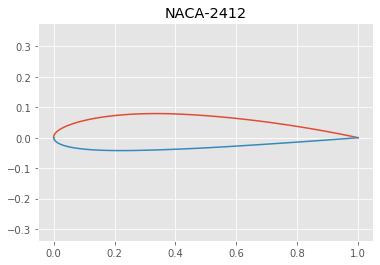

In [4]:
airfoil = generate_airfoil(NACA, N=NUM_POINTS_X)

airfoil.plot()

Get the $(x,y)$ coordinates of the boundary points in the **clockwise** direction, starting at the trailing-edge. 

In [5]:
x, y = airfoil.clockwise_naca()

# Enforce actual zeros
x = np.where(np.isclose(x, 0), 0, x)
y = np.where(np.isclose(y, 0), 0, y)

### Panel generation

Build a list of panels in the **clockwise** direction. 

In [6]:
N_b = len(x)

x_c   = np.zeros(N_b - 1)
y_c   = np.zeros(N_b - 1)
S     = np.zeros(N_b - 1)
theta = np.zeros(N_b - 1)
normals = []
lines = []

idx = 0
for xs, xe, ys, ye in zip(x, x[1:], y, y[1:]):
    
    # Control points
    x_c[idx] = (xs + xe) / 2.0
    y_c[idx] = (ys + ye) / 2.0
    
    # Length
    _S     = (xe - xs)**2.0 + (ye - ys)**2.0
    S[idx] = np.sqrt(_S) 
    
    # Angle
    theta[idx] = np.arctan2(ye - ys , 
                            xe - xs)
    
    #########
    # Vectors
    #########
    # Normal
    normal = np.array([-(ye-ys), (xe-xs)])
    normal = normal / np.linalg.norm(normal)
    
    normals.append(normal)
    
    # Line
    line = np.array([(xe-xs), (ye-ys)])
    line = line / np.linalg.norm(line)
    
    lines.append(line)
    
    # Update index counter
    idx += 1

normals = np.array(normals)
lines = np.array(lines)

## Build system matrices

* No penetration equations.
* Tangential velocity computation.

In [7]:
Cn1 = np.zeros(shape = (N_b-1, N_b-1))
Cn2 = np.zeros(shape = (N_b-1, N_b-1))

Ct1 = np.zeros(shape = (N_b-1, N_b-1))
Ct2 = np.zeros(shape = (N_b-1, N_b-1))

for i in range(N_b-1):
    for j in range(N_b-1):
    
        # Fill-in diagonals
        if i == j:
            
            Cn1[i,j] = -1
            Cn2[i,j] =  1 
            
            Ct1[i,j] = 0.5 * np.pi
            Ct2[i,j] = 0.5 * np.pi
        
        else:
            
            dx = x_c[i] - x[j]
            dy = y_c[i] - y[j]
            
            A = - dx * np.cos(theta[j]) - dy * np.sin(theta[j])
            E =   dx * np.sin(theta[j]) - dy * np.cos(theta[j])
            
            B = dx**2.0 + dy**2.0
            
            C = np.sin(theta[i] - theta[j])
            D = np.cos(theta[i] - theta[j])
            
            F = np.log(1.0 + ((S[j])**2.0 + (2.0 * A * S[j])) / B)
            
            G = np.arctan2((E*S[j]) , (B + A * S[j]))
            
            P = (dx * np.sin(theta[i] - 2.0 * theta[j])) + (dy * np.cos(theta[i] - 2.0 * theta[j]))
            Q = (dx * np.cos(theta[i] - 2.0 * theta[j])) - (dy * np.sin(theta[i] - 2.0 * theta[j]))
            
            # Normal matrix
            Cn2[i,j] = D + ((0.5 * Q * F) / S[j]) - ((A*C + D*E) * (G / S[j]))
            Cn1[i,j] = 0.5*D*F + C*G - Cn2[i,j]
            
            # Tangential matrix
            Ct2[i,j] = C + ((0.5 * P * F) / S[j]) + ((A*D - C*E) * (G / S[j]))
            Ct1[i,j] = 0.5*C*F - D*G - Ct2[i,j]

In [13]:
def contribution_vortex_normal(i, j, gamma):
    """
    Compute the normal contribution of the j-th panel 
    over the i-th control point.

    Parameters
    ----------
    i: int
    j: int
    gamma: 1D np.array

    Returns
    -------
    float
    """
    return Cn1[i,j] * gamma[j] + Cn2[i,j] * gamma[j+1]

def contribution_vortex_tangential(i, j, gamma):
    """
    Compute the tangential contribution of the j-th panel 
    over the i-th control point.

    Parameters
    ----------
    i: int
    j: int
    gamma: 1D np.array

    Returns
    -------
    float
    """
    return Ct1[i,j] * gamma[j] + Ct2[i,j] * gamma[j+1]

In [13]:
def gammas_matrix_equations(gamma):
    """
    Matrix-vector product implementation of the linear system:

    * No penetration condition at the control points.
    * Kutta condition at the TE. 

    Parameters
    ----------
    gamma: 1D np.array

    Returns
    -------
    np.array
    """ 
    # Prepare result
    result = np.zeros_like(gamma)
    
    # Matrix-product implementation
    for i in range(len(result)-1):
        for j in range(len(gamma)-1):
            
            result[i] += contribution_vortex_normal(i, j, gamma)
            
    # Compatibility condition at the end
    result[-1] = gamma[0] + gamma[-1]
    
    return result

All the above defines the geometry of the problem. From now on, the problem matrices are freezed for the given airfoil and the number of discretization panels.

The following blocks of code will implement the solution of the problem. 

---